<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 35px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>User Clustering: <strong>E-Commerce</strong></center></div>
<div style= "font-size: 30px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Organizing all variables and data to the models phase</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Processamento e Modelação de Big Data 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

In [1]:
# Importações Básicas
import pyspark
import pandas as pd
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.functions import split, isnan, col, isnull, avg, count, round
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)


# Create a Spark session
spark = SparkSession.builder \
    .appName("PMBD") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

In [2]:
# Criação da Sessão
spark = SparkSession.builder.appName("Projeto").getOrCreate()

# Leitura de dados
data_dir = '../data/raw/'
file_ec = data_dir + 'user_df_full.parquet'

# Carrega as primeiras 10.000 linhas
ec_user = spark.read.parquet(file_ec)

In [3]:
ec_user = ec_user.repartition(36, "total_views")

In [4]:
ec_user.show()

+---------+-------------+-----------+-----------+----------+---------+-------+---------+----+------------+----+-----------+-----+
|  user_id|average_price|total_views|electronics|appliances|computers|apparel|furniture|auto|construction|kids|accessories|sport|
+---------+-------------+-----------+-----------+----------+---------+-------+---------+----+------------+----+-----------+-----+
|512405720|      277.704|        182|         46|       101|       26|      2|        7|   0|           0|   0|          0|    0|
|512534042|      199.962|        163|         80|        71|       10|      1|        0|   1|           0|   0|          0|    0|
|512543296|      303.656|        183|         89|        22|       19|      1|        0|  52|           0|   0|          0|    0|
|512543628|      481.769|        584|         50|         0|      533|      1|        0|   0|           0|   0|          0|    0|
|512566135|      193.716|        294|        145|         6|        8|    128|        5|  

## Clustering Algorithms

In [5]:
feature_cols = ec_user.columns
feature_cols.pop(0)

'user_id'

In [6]:
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler

In [7]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_prescale")
client_features = assembler.transform(ec_user)

scaler = MaxAbsScaler(inputCol="features_prescale", outputCol="features")
client_features = scaler.fit(client_features).transform(client_features).repartition(36, "total_views")

In [8]:
client_features.show()

+---------+-------------+-----------+-----------+----------+---------+-------+---------+----+------------+----+-----------+-----+--------------------+--------------------+
|  user_id|average_price|total_views|electronics|appliances|computers|apparel|furniture|auto|construction|kids|accessories|sport|   features_prescale|            features|
+---------+-------------+-----------+-----------+----------+---------+-------+---------+----+------------+----+-----------+-----+--------------------+--------------------+
|512405720|      277.704|        182|         46|       101|       26|      2|        7|   0|           0|   0|          0|    0|[277.704,182.0,46...|[0.10788517794776...|
|512534042|      199.962|        163|         80|        71|       10|      1|        0|   1|           0|   0|          0|    0|[199.962,163.0,80...|[0.07768320208852...|
|512543296|      303.656|        183|         89|        22|       19|      1|        0|  52|           0|   0|          0|    0|[303.656,18

In [9]:
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [10]:
silhouette_score=dict()
models = [KMeans(), GaussianMixture(), BisectingKMeans()]
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='features',  
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 

for model in models:
    print(f"Now iterating over {model}")
    silhouette_score[str(model)] = []
    model = model.setFeaturesCol('features').setSeed(42).setMaxIter(10)
    for i in range(2,10): 
        model = model.setK(i)
        fitted_model=model.fit(client_features) 
        predictions=fitted_model.transform(client_features) 
        score=evaluator.evaluate(predictions) 
        silhouette_score[str(model)].append(score) 
        print('Silhouette Score for k =',i,'is',score)
    print()

Now iterating over KMeans_66c386921fb2
Silhouette Score for k = 2 is 0.8431160388244268
Silhouette Score for k = 3 is 0.7853307449182396
Silhouette Score for k = 4 is 0.7499025765152058
Silhouette Score for k = 5 is 0.699390891457081
Silhouette Score for k = 6 is 0.6689864549506925
Silhouette Score for k = 7 is 0.6631063200337115
Silhouette Score for k = 8 is 0.6270351009774507
Silhouette Score for k = 9 is 0.6345734538432664

Now iterating over GaussianMixture_3d8a92ed432e
Silhouette Score for k = 2 is -0.33965023318831067
Silhouette Score for k = 3 is -0.3534151970347416
Silhouette Score for k = 4 is -0.3594276854004713
Silhouette Score for k = 5 is -0.5356587132213272
Silhouette Score for k = 6 is -0.5841512536258913
Silhouette Score for k = 7 is -0.5159421725819028
Silhouette Score for k = 8 is -0.5691477303349796
Silhouette Score for k = 9 is -0.6039728735852774

Now iterating over BisectingKMeans_32c86c8c26c9
Silhouette Score for k = 2 is 0.8429324274621157
Silhouette Score for k

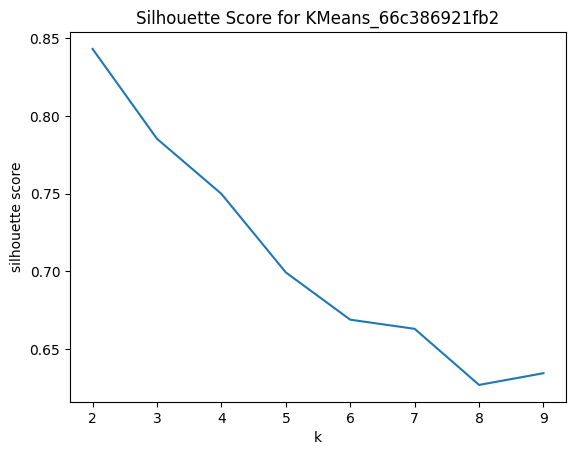

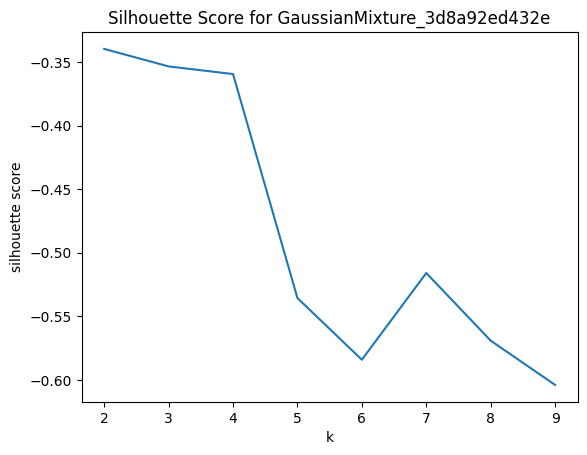

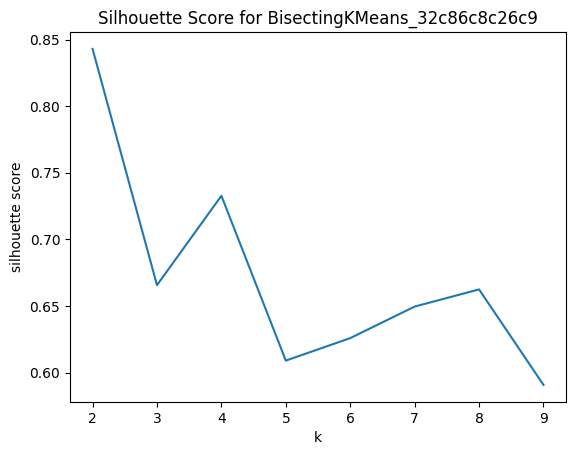

In [11]:
import matplotlib.pyplot as plt 
  
for model in models:
    plt.plot(range(2,10),silhouette_score[str(model)]) 
    plt.xlabel('k') 
    plt.ylabel('silhouette score') 
    plt.title(f'Silhouette Score for {model}') 
    plt.show()

In [12]:
print(models)

[KMeans_66c386921fb2, GaussianMixture_3d8a92ed432e, BisectingKMeans_32c86c8c26c9]


In [23]:
chosen_model = models[0]
optimal_k = silhouette_score[str(chosen_model)].index(max(silhouette_score[str(chosen_model)])) + 2

In [26]:
# Trains a k-means model.
model = chosen_model.setSeed(42).setFeaturesCol("features").setK(optimal_k)
fitted_model = model.fit(client_features)
print(f"Cluster Sizes: {fitted_model.summary.clusterSizes}")

# Make predictions
predictions = fitted_model.transform(client_features)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = fitted_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Sizes: [3519106, 780825]
Silhouette with squared euclidean distance = 0.8431160388244268
Cluster Centers: 
[9.05217392e-02 1.18889830e-03 8.59670069e-04 5.66489127e-04
 5.10345679e-04 5.30525337e-04 7.24529602e-04 6.58811911e-05
 1.83672729e-04 2.55776686e-05 2.57938770e-04 1.47161397e-04]
[3.67375556e-01 9.15078369e-04 9.34354252e-04 1.40982607e-04
 8.77848552e-04 6.80579309e-05 2.57436922e-04 1.13659350e-05
 2.94935928e-05 4.76215239e-06 6.34972611e-05 9.51151424e-05]


In [27]:
predictions.groupBy("prediction").count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         1| 780825|
|         0|3519106|
+----------+-------+



In [28]:
cluster_profiles = predictions.groupBy("prediction").mean()

In [29]:
for c in cluster_profiles.columns:
    cluster_profiles = cluster_profiles.withColumn(c, F.round(c, 2))

In [30]:
cluster_profiles.show()

+----------+--------------+------------------+----------------+----------------+---------------+--------------+------------+--------------+---------+-----------------+---------+----------------+----------+---------------+
|prediction|  avg(user_id)|avg(average_price)|avg(total_views)|avg(electronics)|avg(appliances)|avg(computers)|avg(apparel)|avg(furniture)|avg(auto)|avg(construction)|avg(kids)|avg(accessories)|avg(sport)|avg(prediction)|
+----------+--------------+------------------+----------------+----------------+---------------+--------------+------------+--------------+---------+-----------------+---------+----------------+----------+---------------+
|         1| 5.463074761E8|            945.73|           13.12|            9.21|           0.86|          2.23|        0.16|          0.31|      0.1|             0.08|     0.07|            0.04|      0.07|            1.0|
|         0|5.4604055005E8|            233.03|           17.05|            8.48|           3.46|           1.3| 

In [22]:
# write in a parquet file
predictions.drop("features_prescale", "features").write.parquet(data_dir + "user_cluster_df_full.parquet", mode="overwrite")